In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [2]:
def write_to_csv(loans):
    num_files = 4
    num_loans = loans.shape[0]
    loans_per_file = num_loans / num_files
    print "%d loans per file" % loans_per_file
    start = 0
    index = 0
    while start < num_loans:
        filename = './data/loans_2012_to_2013_' + str(index) + '.csv'
        loans[start:start+loans_per_file].to_csv(filename, index=False)
        print "%s;%d;%d" % (filename, start, start+loans_per_file)
        start += loans_per_file
        index += 1

## Read in dataset of all loans issued by Lending Club in 2012 and 2013

In [3]:
def read_from_csv():
    dataframes = []
    for i in range(5):
        filename = './data/loans_2012_to_2013_' + str(i) + '.csv'
        df = pd.read_csv(filename, low_memory=False)
        dataframes.append(df)
    loans = pd.concat(dataframes)
    return loans

In [4]:
loans = read_from_csv()

# 154,621 of the 188,181 loans were taken out for credit card debt consolidation. We will only look at those loans for this analysis

In [5]:
loans.shape

(188181, 145)

In [6]:
loans.purpose.value_counts()

debt_consolidation    111451
credit_card            43170
home_improvement       10297
other                   8896
major_purchase          3659
small_business          2745
car                     1951
medical                 1519
wedding                 1331
house                   1093
moving                  1038
vacation                 909
renewable_energy         122
Name: purpose, dtype: int64

In [7]:
consolidation_loans = loans[(loans['purpose'] == 'debt_consolidation') | (loans['purpose'] == 'credit_card')]

In [8]:
consolidation_loans.shape

(154621, 145)

# Some exploratory data analysis

First remove all loans that haven't matured yet.
We want to know
* average interest rate by subgrade
* average other debt. Any correlation to loan amount or grade.
* amortization chart of high vs low interest
* default rate by subgrade
* model of reducing interest rate by x% for good behavior, decrease default by y%. Is return of portfolio greater?

In [9]:
consolidation_loans.loan_status.value_counts()

Fully Paid            123870
Charged Off            23745
Current                 6588
Late (31-120 days)       224
In Grace Period          140
Late (16-30 days)         53
Default                    1
Name: loan_status, dtype: int64

In [10]:
# Remove whitespace from term and loan_status
consolidation_loans.term = consolidation_loans.term.apply(lambda x: x.strip())
consolidation_loans.loan_status = consolidation_loans.loan_status.apply(lambda x: x.strip())
consolidation_loans['defaulted'] = consolidation_loans.loan_status.apply(lambda x: 1 if x == 'Charged Off' else 0)

/Users/anishb/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/anishb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
# Remove loans that are still current
consolidation_loans = consolidation_loans.loc[(consolidation_loans.loan_status == 'Fully Paid')
                                              | (consolidation_loans.loan_status == 'Charged Off'),]

In [12]:
# Convert int_rate to a float
consolidation_loans.int_rate = consolidation_loans.int_rate.apply(lambda x: float(x.strip()[:-1]))

## Following conventions, interest rate is directly proportional to borrower credit risk

In [13]:
# Average interest rate and charge off by subgrade
sub_grades = pd.unique(consolidation_loans.sub_grade)
sub_grades.sort()
mean_int_rates = []
charge_off_percentage = []
for sub_grade in sub_grades:
    mean_int_rates.append(consolidation_loans.loc[consolidation_loans.sub_grade == sub_grade, 'int_rate'].mean())
    num_charge_offs = consolidation_loans.loc[(consolidation_loans.sub_grade == sub_grade)
                                              & (consolidation_loans.loan_status == 'Charged Off')].shape[0]
    num_loans = consolidation_loans.loc[(consolidation_loans.sub_grade == sub_grade)].shape[0]
    charge_off_percentage.append(float(num_charge_offs) / num_loans)

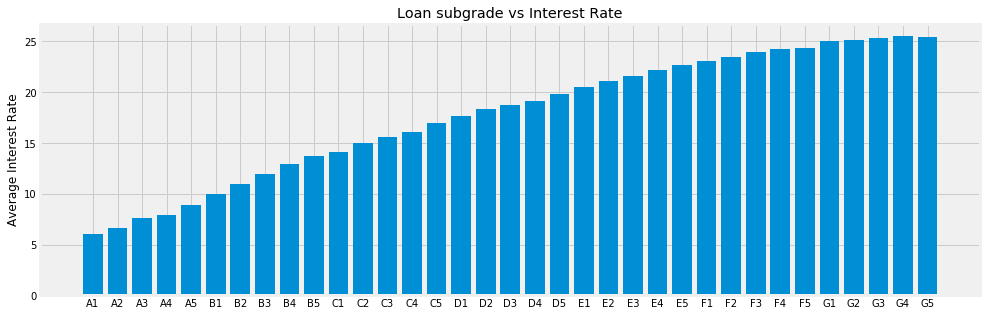

In [14]:
fig = plt.figure(figsize=(15, 5))
bar_locations = np.arange(len(sub_grades))
plt.bar(bar_locations, mean_int_rates);
plt.xticks(bar_locations, sub_grades)
plt.ylabel('Average Interest Rate')
plt.title('Loan subgrade vs Interest Rate')
plt.figure(figsize=(35,5))
plt.show()

## As expected, default rates are higher in the lower grade loans

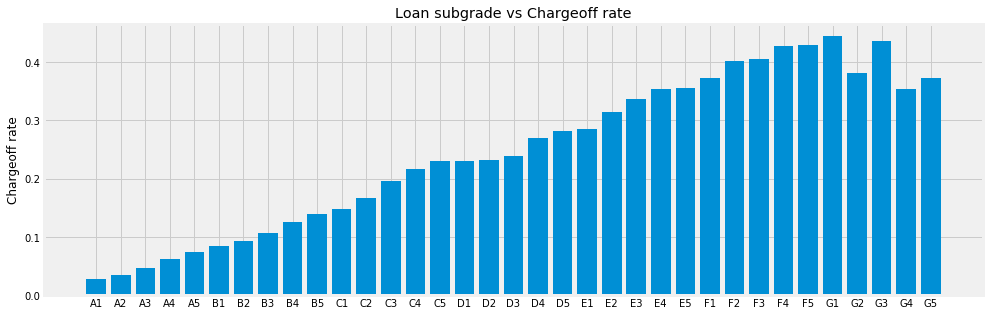

In [15]:
fig = plt.figure(figsize=(15, 5))
bar_locations = np.arange(len(sub_grades))
plt.bar(bar_locations, charge_off_percentage);
plt.xticks(bar_locations, sub_grades)
plt.ylabel('Chargeoff rate')
plt.title('Loan subgrade vs Chargeoff rate')
plt.figure(figsize=(35,5))
plt.show()

## What are indicators of a borrower risk?

In [16]:
loans_risk = consolidation_loans[['defaulted', 'dti', 'delinq_2yrs', 'revol_util', 'inq_last_6mths', 'total_bal_ex_mort', 'mths_since_last_delinq']]
loans_risk = loans_risk[loans_risk.revol_util.notnull()]
loans_risk['revol_util'] = loans_risk.revol_util.apply(lambda x: float(x.strip()[:-1]))

In [17]:
loans_risk.corr()

,defaulted,dti,delinq_2yrs,revol_util,inq_last_6mths,total_bal_ex_mort,mths_since_last_delinq
defaulted,1.000000,0.088044,0.004091,0.066546,0.059740,-0.010195,0.000028
dti,0.088044,1.000000,-0.013931,0.155837,0.026787,0.308753,0.020216
delinq_2yrs,0.004091,-0.013931,1.000000,-0.019880,0.025075,0.032252,-0.588938
revol_util,0.066546,0.155837,-0.019880,1.000000,-0.081729,0.100757,0.037840
inq_last_6mths,0.059740,0.026787,0.025075,-0.081729,1.000000,0.087402,-0.003432
total_bal_ex_mort,-0.010195,0.308753,0.032252,0.100757,0.087402,1.000000,-0.027853
mths_since_last_delinq,0.000028,0.020216,-0.588938,0.037840,-0.003432,-0.027853,1.000000


As expected, dti (debt to income ratio), number of credit inquiries in the past 6 months, and revolving credit utilization have a strong correlation to borrower default.

## Let's take a look at 3 year loans

In [18]:
a_avg_int_rate = consolidation_loans.loc[((consolidation_loans.grade == 'A') &
                                          (consolidation_loans.term == '36 months')),].int_rate.mean()
g_avg_int_rate = consolidation_loans.loc[((consolidation_loans.grade == 'G') &
                                         (consolidation_loans.term == '36 months')),].int_rate.mean()
average_loan_amount = consolidation_loans.loc[consolidation_loans.term == '36 months'].loan_amnt.mean()
print 'Average Grade A Interest Rate = %f' % a_avg_int_rate
print 'Average Grade G Interest Rate = %f' % g_avg_int_rate
print 'Average loan amount = $%d' % int(average_loan_amount)

Average Grade A Interest Rate = 7.722641
Average Grade G Interest Rate = 24.969615
Average loan amount = $12983


In [19]:
class FixedInterestCalculator(object):
    
    def __init__(self, principal, interest_rate, num_months):
        self.principal = principal
        self.interest_rate = interest_rate
        self.num_months = num_months
        self._rate_per_month = interest_rate / 12.0
        self._monthly_payment = self.monthly_payment()
        self._balance = {}
        self._interest_payment = {}
        self._principal_payment = {}
        
    def monthly_payment(self):
        r = self.interest_rate / 12.0
        payment = (r * self.principal) / (1 - (1 + r)**(-self.num_months))
        return payment
    
    def balance(self, month):
        if month == 0:
            return self.principal
        if month in self._balance:
            return self._balance[month]
        self._balance[month] = self.balance(month - 1) - self.principal_payment(month)
        return self._balance[month]
    
    def interest_payment(self, month):
        if month == 0:
            return 0.0
        if month in self._interest_payment:
            return self._interest_payment[month]
        self._interest_payment[month] = self._rate_per_month * self.balance(month - 1)
        return self._interest_payment[month]
    
    def principal_payment(self, month):
        if month == 0:
            return 0.0
        if month in self._principal_payment:
            return self._principal_payment[month]
        self._principal_payment[month] = self._monthly_payment - self.interest_payment(month)
        return self._principal_payment[month]
    
    def total_interest(self):
        return (self.num_months * self._monthly_payment) - self.principal

### What does the amortization look like for the average grade A, 3 year loan => 12,983 at 7.72% interest

In [20]:
calculator = FixedInterestCalculator(12983.00, 0.0772, 36)
months = np.arange(1, 37)
interest, principal = [], []
for month in months:
    interest.append(calculator.interest_payment(month))
    principal.append(calculator.principal_payment(month))

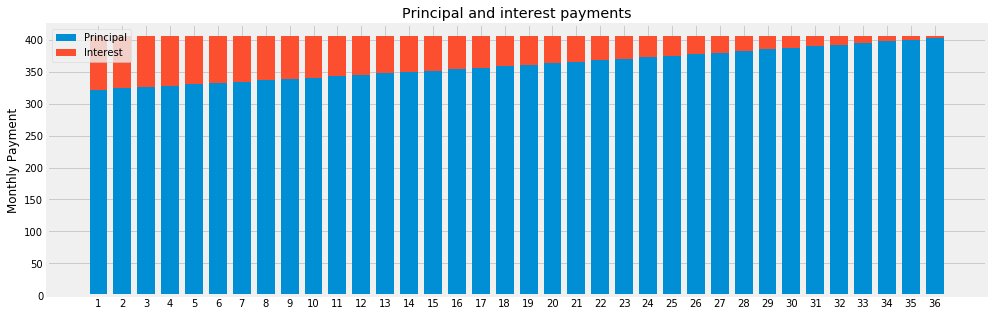

In [21]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, principal, width)
p2 = plt.bar(months, interest, width, bottom=principal)
plt.ylabel('Monthly Payment')
plt.title('Principal and interest payments')
plt.xticks(months)
plt.legend((p1[0], p2[0]), ('Principal', 'Interest'))
plt.figure(figsize=(60,5))
plt.show();

In [22]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % calculator.total_interest()

Monthly payments = $405.17
Total interest paid = $1602.94


### What does the respective amortization look like for the average grade G, 3 year loan => 12,983 at 24.97% interest

In [23]:
calculator = FixedInterestCalculator(12983.00, 0.2497, 36)
months = np.arange(1, 37)
interest, principal = [], []
for month in months:
    interest.append(calculator.interest_payment(month))
    principal.append(calculator.principal_payment(month))

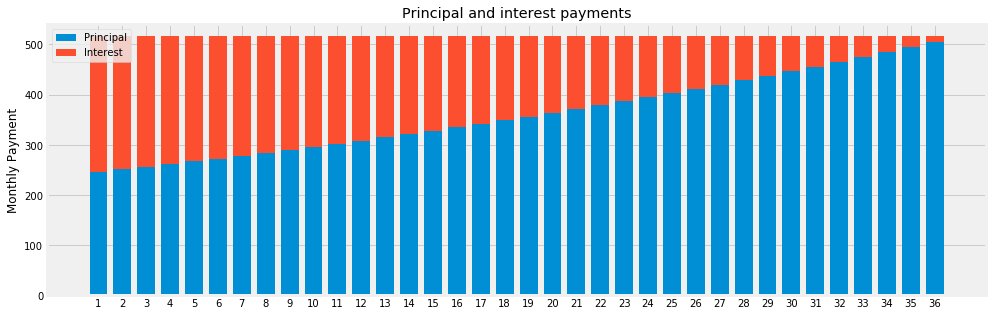

In [24]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, principal, width)
p2 = plt.bar(months, interest, width, bottom=principal)
plt.ylabel('Monthly Payment')
plt.title('Principal and interest payments')
plt.xticks(months)
plt.legend((p1[0], p2[0]), ('Principal', 'Interest'))
plt.figure(figsize=(60,5))
plt.show();

In [25]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % calculator.total_interest()

Monthly payments = $516.00
Total interest paid = $5592.85


### What if we raise the interest by 10%, but incentivize the borrower to exhibit good financial behavior with a 30% rebate on interest payments?

In [26]:
class RebateInterestCalculator(FixedInterestCalculator):
    
    def __init__(self, principal, interest_rate, num_months, rebate_rate):
        super(RebateInterestCalculator, self).__init__(principal, interest_rate, num_months)
        self.rebate_rate = rebate_rate
        
    def total_rebates(self):
        return self.total_interest() * self.rebate_rate
    
    def rebate(self, month):
        if month == 0:
            return 0.0
        index = self.num_months - month + 1
        return self.interest_payment(index) * self.rebate_rate
    
    def effective_interest(self):
        return self.total_interest() - self.total_rebates()

In [27]:
calculator = RebateInterestCalculator(12983.00, 0.2497 * 1.10, 36, 0.30)
months = np.arange(1, 37)
rebates = []
for month in months:
    rebates.append(calculator.rebate(month))

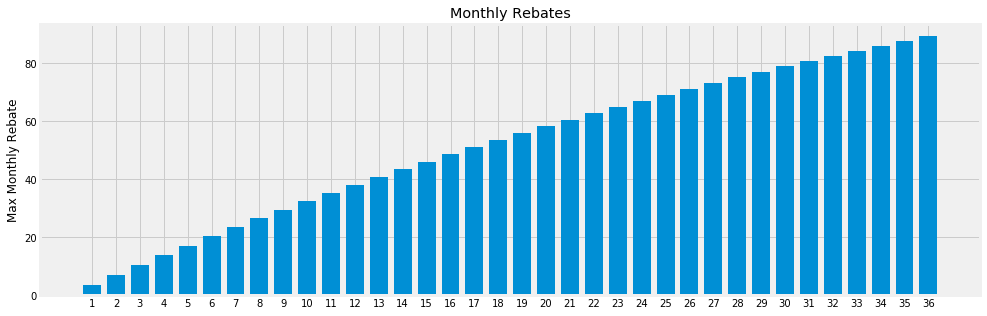

In [28]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, rebates, width)
plt.ylabel('Max Monthly Rebate')
plt.title('Monthly Rebates')
plt.xticks(months)
plt.figure(figsize=(60,5))
plt.show();

In [29]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % calculator.total_interest()
print "Max rebates earnable = $%.2f" % calculator.total_rebates()
print "Efective interest paid = $%.2f" % calculator.effective_interest()

Monthly payments = $533.29
Total interest paid = $6215.51
Max rebates earnable = $1864.65
Efective interest paid = $4350.86


### What does this look like for a typical grade A loan? Not that much in rebates

In [30]:
calculator = RebateInterestCalculator(12983.00, 0.0772 * 1.10, 36, 0.30)
months = np.arange(1, 37)
rebates = []
for month in months:
    rebates.append(calculator.rebate(month))

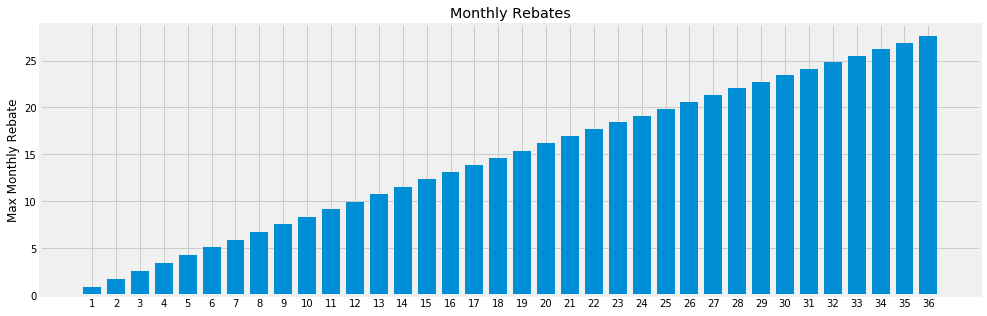

In [31]:
width = 0.75
fig = plt.figure(figsize=(15, 5))
p1 = plt.bar(months, rebates, width)
plt.ylabel('Max Monthly Rebate')
plt.title('Monthly Rebates')
plt.xticks(months)
plt.figure(figsize=(60,5))
plt.show();

In [32]:
print "Monthly payments = $%.2f" % calculator.monthly_payment()
print "Total interest paid = $%.2f" % calculator.total_interest()
print "Max rebates earnable = $%.2f" % calculator.total_rebates()
print "Efective interest paid = $%.2f" % calculator.effective_interest()

Monthly payments = $409.79
Total interest paid = $1769.56
Max rebates earnable = $530.87
Efective interest paid = $1238.69


In [33]:
from random import random
from datetime import datetime
class YieldSimulator(object):
    
    def __init__(self, dataframe, rate_adjustment, rebate_rate, default_decrease_rate):
        self.df = dataframe.copy()
        self.rate_adjustment = rate_adjustment
        self.rebate_rate = rebate_rate
        self.default_decrease_rate = default_decrease_rate
        
    def _num_payments_made(self, row):
        issue_date = datetime.strptime(row.issue_d, '%b-%Y')
        last_payment_date = datetime.strptime(row.last_pymnt_d, '%b-%Y')
        if last_payment_date.month >= issue_date.month:
            years = last_payment_date.year - issue_date.year
            num_payments = years * 12
            num_payments += last_payment_date.month - issue_date.month
        else:
            years = last_payment_date.year - issue_date.year - 1
            num_payments = years * 12
            num_payments += 12 - (issue_date.month - last_payment_date.month)
        return num_payments
        
    def clean(self):
        self.df['num_payments_made'] = self.df.apply(lambda row: self._num_payments_made(row) if pd.notnull(row['last_pymnt_d']) else 0, axis=1)
        self.df['term'] = self.df.term.apply(lambda x: int(x.strip().split(' ')[0]))
    
    def num_loans(self):
        return self.df.shape[0]
    
    def num_loans_charged_off(self):
        return self.df.loc[self.df.loan_status == 'Charged Off',].shape[0]
    
    def num_prepayed(self):
        return self.df.loc[(simulator.df.loan_status == 'Fully Paid') & (self.df.num_payments_made < self.df.term)].shape[0]
    
    def total_collected(self):
        return self.total_interest_collected() + self.total_principal_collected() + self.total_late_fees_collected() \
            + self.total_recovered()
    
    def total_interest_collected(self):
        return self.df['total_rec_int'].sum()
    
    def total_principal_collected(self):
        return self.df['total_rec_prncp'].sum()
    
    def total_late_fees_collected(self):
        return self.df['total_rec_late_fee'].sum()
    
    def total_recovered(self):
        return self.df['recoveries'].sum()
    
    def simulated_interest_collected(self):
        return self.simulated_df['total_rec_int'].sum()
    
    def simulated_principal_collected(self):
        return self.simulated_df['total_rec_prncp'].sum()
    
    def simulated_late_fees_collected(self):
        return self.simulated_df['total_rec_late_fee'].sum()
    
    def simulated_recovered(self):
        return self.simulated_df['recoveries'].sum()
    
    def simulated_rebates(self):
        return self.simulated_df['rebates_earned'].sum()
    
    def simulated_yield(self):
        return self.simulated_interest_collected() + self.simulated_principal_collected() \
        + self.simulated_late_fees_collected() + self.simulated_recovered() - self.simulated_rebates()
    
    def _adjust_charged_off(self, row):
        if row.loan_status == 'Fully Paid':
            return row
        # Assume 50% reduction in charge offs
        if random() > self.default_decrease_rate:
            return row
        calculator = FixedInterestCalculator(row.loan_amnt, row.int_rate / 100.0, row.term)
        row['loan_status'] = 'Fully Paid'
        row['total_rec_prncp'] = row.loan_amnt
        row['total_rec_int'] = calculator.total_interest()
        row['recoveries'] = 0.0
        return row
    
    def _calculate_rebates_earned(self, row):
        calculator = RebateInterestCalculator(row.loan_amnt, row.int_rate / 100.0, row.term, self.rebate_rate)
        num_payments = row.num_payments_made if row.num_payments_made < row.term else row.term
        rebates = []
        for i in xrange(num_payments + 1):
            rebates.append(calculator.rebate(i))
        return sum(rebates)
    
    def simulate(self):
        self.simulated_df = self.df.copy()
        self.simulated_df['int_rate'] = self.simulated_df.int_rate.apply(lambda x: x * (1 + self.rate_adjustment))
        self.simulated_df['total_rec_int'] = self.simulated_df.total_rec_int.apply(lambda x: x * (1 + self.rate_adjustment))
        # Assume delinquencies / late fees go down 75%
        self.simulated_df['total_rec_late_fee'] = self.simulated_df.total_rec_late_fee.apply(lambda x: x * 0.25)
        self.simulated_df = self.simulated_df.apply(self._adjust_charged_off, axis=1)
        self.simulated_df['rebates_earned'] = self.simulated_df.apply(self._calculate_rebates_earned, axis=1)

## Summary of loan portfolio yield without any changes

In [34]:
simulator = YieldSimulator(consolidation_loans, 0.10, 0.30, 0.5)
simulator.clean()
num_loans = simulator.num_loans()
num_charged_off = simulator.num_loans_charged_off()
num_prepayed = simulator.num_prepayed()
print "Number of loans = {}".format(num_loans)
print "Number that defaulted = {} ({:,.2f}%)".format(num_charged_off, num_charged_off * 100.0 / num_loans)
print "Number that prepayed = {} ({:,.2f}%)".format(simulator.num_prepayed(), num_prepayed * 100.0 / num_loans)
print "Total interest collected = ${0:,.2f}".format(simulator.total_interest_collected())
print "Total principal collected = ${0:,.2f}".format(simulator.total_principal_collected())
print "Total late fees collected = ${0:,.2f}".format(simulator.total_late_fees_collected())
print "Total post charge off recoveries = ${0:,.2f}".format(simulator.total_recovered())
print "Total yield = ${0:,.2f}".format(simulator.total_collected())

Number of loans = 147615
Number that defaulted = 23745 (16.09%)
Number that prepayed = 84210 (57.05%)
Total interest collected = $463,937,964.81
Total principal collected = $1,925,798,653.94
Total late fees collected = $131,404.89
Total post charge off recoveries = $28,280,468.63
Total yield = $2,418,148,492.27


## Assume a 10% increase in interest rates and 30% rebates earned per month, resulting in a 50% reduction in delinquincies and defaults.

In [35]:
simulator.simulate()
print "Total interest collected = ${0:,.2f}".format(simulator.simulated_interest_collected())
print "Total principal collected = ${0:,.2f}".format(simulator.simulated_principal_collected())
print "Total late fees collected = ${0:,.2f}".format(simulator.simulated_late_fees_collected())
print "Total post charge off recoveries = ${0:,.2f}".format(simulator.simulated_recovered())
print "Total rebates paid out = ${0:,.2f}".format(simulator.simulated_rebates())
print "Total yield = ${0:,.2f}".format(simulator.simulated_yield())

Total interest collected = $549,494,679.40
Total principal collected = $2,048,200,272.03
Total late fees collected = $32,851.22
Total post charge off recoveries = $13,973,497.15
Total rebates paid out = $97,129,626.69
Total yield = $2,514,571,673.11


## So do these borrowers have other debt?

Since it has more information, let's read in data from the first 3 quarters of 2017. 

In [36]:
def read_from_csv():
    dataframes = []
    for i in range(8):
        filename = './data/loans_2017_Q1_to_Q3_' + str(i) + '.csv'
        df = pd.read_csv(filename, low_memory=False)
        dataframes.append(df)
    loans = pd.concat(dataframes)
    return loans

loans = read_from_csv()

In [37]:
loans.purpose.value_counts()

debt_consolidation    182631
credit_card            66159
home_improvement       26015
other                  22211
major_purchase          7913
medical                 4920
car                     3964
small_business          3445
vacation                3154
moving                  2744
house                   1559
renewable_energy         215
wedding                    1
Name: purpose, dtype: int64

In [38]:
loans = loans[(loans['purpose'] == 'debt_consolidation') | (loans['purpose'] == 'credit_card')]

In [39]:
# Normalize outliers to median
loans.loc[loans.tot_cur_bal > loans.tot_cur_bal.quantile(.98), 'tot_cur_bal'] = loans.tot_cur_bal.median()
loans.loc[loans.total_bal_il > loans.total_bal_il.quantile(.98), 'total_bal_il'] = loans.total_bal_il.median()
loans.loc[loans.open_act_il > loans.open_act_il.quantile(.98), 'open_act_il'] = loans.open_act_il.median()

### Total balance across all loans

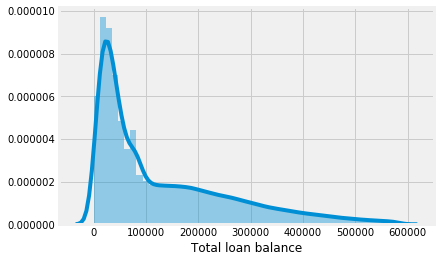

In [40]:
sns.distplot(loans.tot_cur_bal, axlabel='Total loan balance');

### Total balance for installment loans

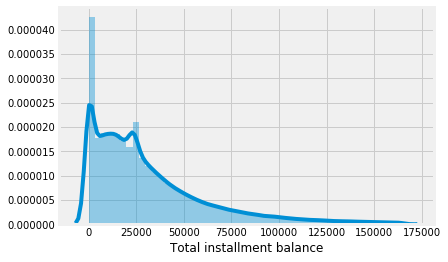

In [41]:
sns.distplot(loans.total_bal_il, axlabel='Total installment balance');

### Number of installment loans

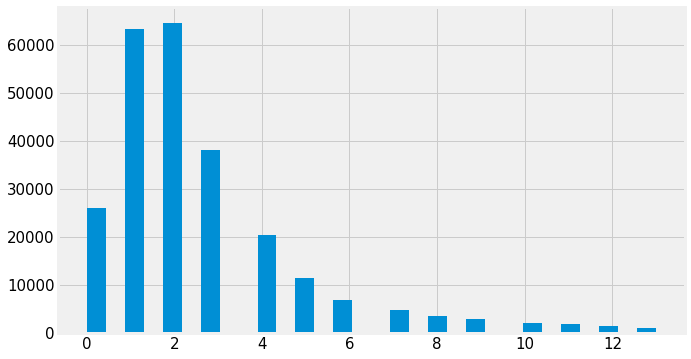

In [42]:
loans.open_act_il.hist(bins=30, figsize=(10, 6), xlabelsize=15, ylabelsize=15)

## About 57% of the loans were prepayed before maturity.

### Number of payments made for 3 year loans that were pre-paid

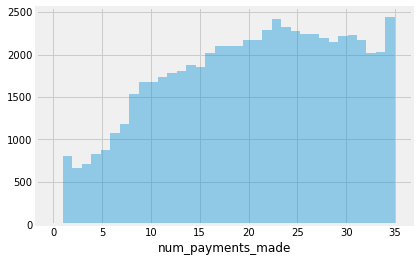

In [43]:
prepaid = simulator.df.loc[(simulator.df.loan_status == 'Fully Paid') & (simulator.df.num_payments_made < simulator.df.term)]
sns.distplot(prepaid.loc[prepaid.term == 36].num_payments_made, kde=False, bins=36);

### Number of payments made for 5 year loans that were pre-paid

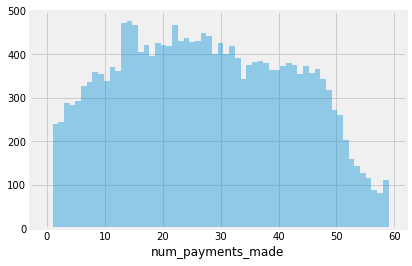

In [44]:
sns.distplot(prepaid.loc[prepaid.term == 60].num_payments_made, kde=False, bins=60);

### Prepayed loans by loan amount for 3 year loans. Smaller loans are more likely to be pre-paid.

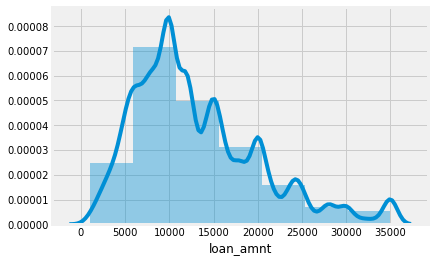

In [45]:
sns.distplot(prepaid.loc[prepaid.term == 36].loan_amnt, bins=7);

### Prepayed loans by loan amount for 5 year loans.

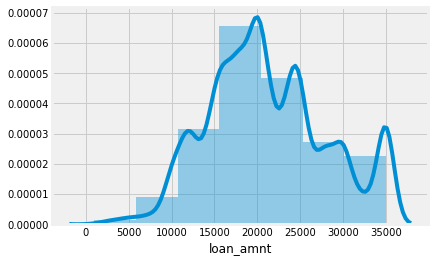

In [46]:
sns.distplot(prepaid.loc[prepaid.term == 60].loan_amnt, bins=7);

## FICO score changes over time

In [55]:
loans['fico_avg'] = loans.apply(lambda row: (row.fico_range_low + row.fico_range_high) / 2, axis=1)
loans['last_fico_avg'] = loans.apply(lambda row: (row.last_fico_range_low + row.fico_range_high) / 2, axis=1)
loans['fico_change'] = loans.apply(lambda row: row.last_fico_avg - row.fico_avg, axis=1)

In [125]:
jan_loans = loans.loc[(loans.issue_d == 'Jan-2017') & (loans.last_credit_pull_d == 'Dec-2017') & (loans.loan_status == 'Current')]

### Change in FICO score from Jan 2017 to Dec 2017

In [131]:
print "Min change = {}".format(jan_loans.fico_change.min())
print "Max change = {}".format(jan_loans.fico_change.max())
print "Average change = {}".format(jan_loans.fico_change.mean())

Min change = -340.0
Max change = 77.5
Average change = 2.08994034569


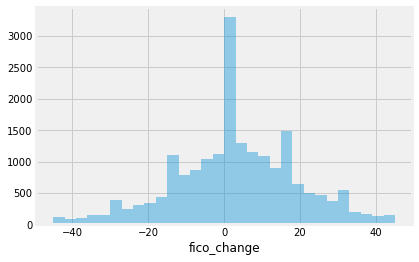

In [132]:
jan_loans.loc[abs(jan_loans.fico_change) > jan_loans.fico_change.quantile(.99), 'fico_change'] = jan_loans.fico_change.median()
sns.distplot(jan_loans.fico_change, bins=30, kde=False);